In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import astropy.units as u
from astropy.coordinates import Angle


from models import session, TanWcs, RectangularCoords, RectangularHeliocentricCoords, rect2sphere

%matplotlib inline

# Region search

The goal of the notebook is to demonstrate the minimum requirements for a region search module for KBMOD and related issues with trying to perform region search on spherical systems. 

A fake database is created, `example.sqlite3`, that contains the minimum required data to record a partially-complete WCS. The WCS is only a partial one, because it represents a simple `TAN` projection for an `(1000, 1000)` image without specifying the coordinate system and scale. They all have the same reference pixel and the linear distortion coefficients to the sky coordinates, which is a realistic scenario for an space observatory with excellent instrumentation over reasonably-short time periods.

Each WCS, however, will have a different value of the reference pixel's sky coordinates. These are assigned randomly and do not represent any particular cadence, which is not a very realistic scenario.

The WCS is also used to calculate the on-sky coordinates of the `[0,0]`th pixel. This is not immediately important for us, but is important when trying to calculate overlap.These, `refpix` and `corner`, coordinates are then converted to cartesian (rectangular) representation.         
See `create_db.py` for details. 

The database contains 30 000 faked WCS's demonstrating that search performance is really not an issue, even when indexing is not present.          

There are two important tables for this bit - `TanWCS` representing our on-sky pointings and the `GeometricCoords` representing the Cartesian representation of whatever spherical coordinate system the WCS is expressed in.       
See `models.py` for database schema.  

First, let's visualize all our fake pointings and showcase how both approaches can seemingly work ok.

In [2]:
# all faked pointings
all_pointings = TanWcs.all()

# pointings selected in a square around their sky coordinates
sky_pointings = TanWcs.query_square_naive(160, 0, 25)
        
# pointings selected in (approximately) the same square around their cartesian coordinates
cart_pointing = RectangularCoords.query_square(160, 0, 25)

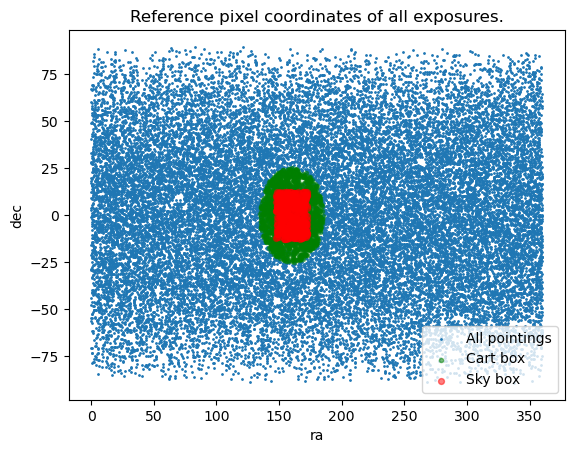

In [3]:
plt.scatter(all_pointings[:, 0], all_pointings[:, 1], s=1, label="All pointings")
plt.scatter(cart_pointing[:, 0], cart_pointing[:, 1], s=9, color="green", alpha=0.5, label="Cart box")
plt.scatter(sky_pointings[:, 0], sky_pointings[:, 1], s=18, color="red", alpha=0.5, label="Sky box")


plt.xlabel("ra")
plt.ylabel("dec")
plt.title("Reference pixel coordinates of all exposures.")
plt.legend()

On the plot we the blue dots are all faked pointings. The created pointings span the whole sky.       
The green and red dots in the middle are pointings selected in a 25 degree region around `(160, 0)` degrees. The red dots were selected from the table of all pointings, by drawing a simple box around the sky coordinates. The range of this box is approximately `148-->172 deg ra` and `-12-->12 deg dec`. The green dots were selected by converting the pointing `(ra, dec)` to cartesian `(x, y, z)` before selecting, approximately, the same rectangle. The red dots are plotted with a slightly larger radii than the green or blue ones, so as to avoid being obscured by the overplotted green dots.

So all is well, everything seems to match - wonderful. Unless we select an area closer to the corners of the projection.

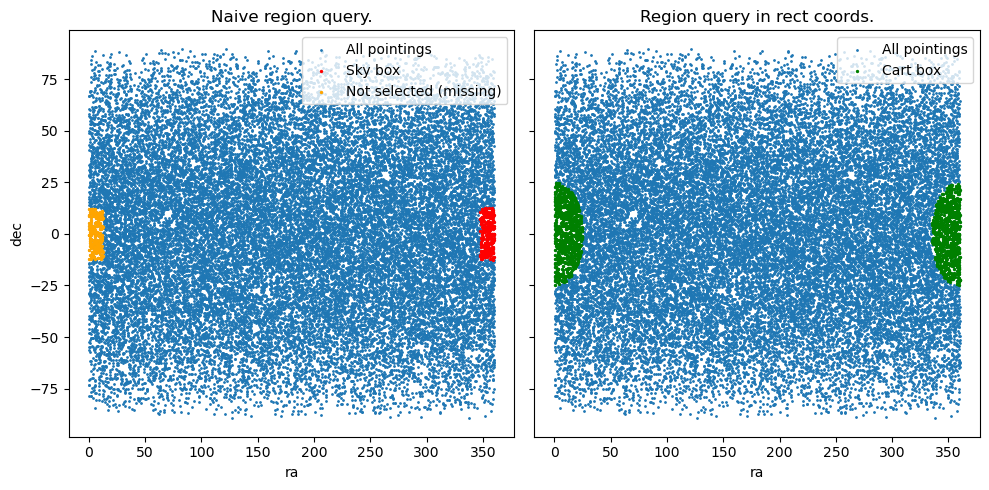

In [4]:
sky_pointings = TanWcs.query_square_naive(360, 0, 25)
cart_pointing = RectangularCoords.query_square(360, 0, 25)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

axes[0].scatter(all_pointings[:, 0], all_pointings[:, 1], s=1, label="All pointings")
axes[1].scatter(all_pointings[:, 0], all_pointings[:, 1], s=1, label="All pointings")

axes[0].scatter(sky_pointings[:, 0], sky_pointings[:, 1], s=2, color="red", label="Sky box")
missing_selection = TanWcs.query_square_naive(0, 0, 25)
axes[0].scatter(missing_selection[:, 0], missing_selection[:, 1], 
                s=2, color="orange", label="Not selected (missing)")

axes[1].scatter(cart_pointing[:, 0], cart_pointing[:, 1], s=2, color="green", label="Cart box")

axes[0].legend()
axes[1].legend()
axes[0].set_ylabel("dec")
axes[0].set_xlabel("ra")
axes[1].set_xlabel("ra")
axes[0].set_title("Naive region query.")
axes[1].set_title("Region query in rect coords.")
plt.tight_layout()

## Why this works?

Because the cartesian cooridnates act as homogeneous coordinates for a sphere. If you project a sphere to a plane, you can't tell which points belong to the face looking towards you and which ones look away from you. The cartesial coordinates are the natural choice of index to resolve this degeneracy.

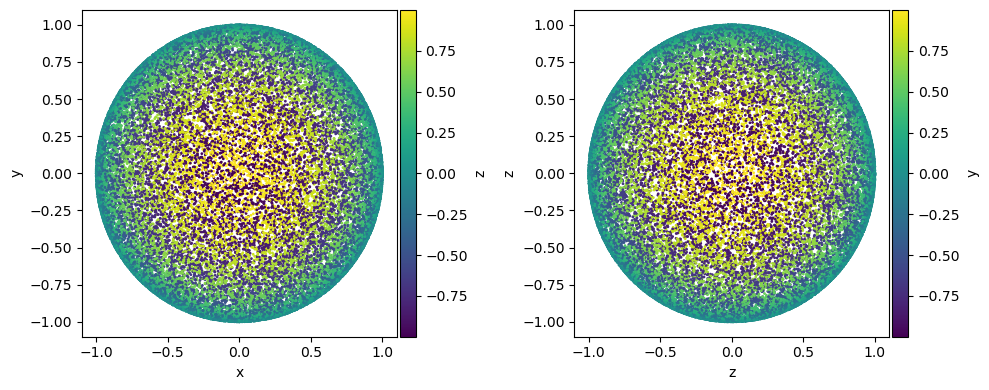

In [5]:
all_cart = RectangularCoords.all()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

s1 = axes[0].scatter(all_cart[:, 0], all_cart[:, 1], s=1, c=all_cart[:, 2])
s2 = axes[1].scatter(all_cart[:, 0], all_cart[:, 2], s=1, c=all_cart[:, 1])

divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad="1%")
fig.colorbar(s1, cax=cax, label="z")

divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad="1%")
fig.colorbar(s2, cax=cax, label="y")

axes[0].set_ylabel("y")
axes[0].set_xlabel("x")
axes[1].set_ylabel("z")
axes[1].set_xlabel("x")
axes[1].set_xlabel("z")

plt.tight_layout()

# Why it matters?

Because selections around poles are very dificult to execute if you need to do math. The basic reason is that for each point you need to perform a distance on a sphere calculation between two points. While there is an explicit expression for a geodesic on a sphere it's quite expensive and numerically unstable for small distances, see [wiki](https://en.wikipedia.org/wiki/Great-circle_distance#Formulae)

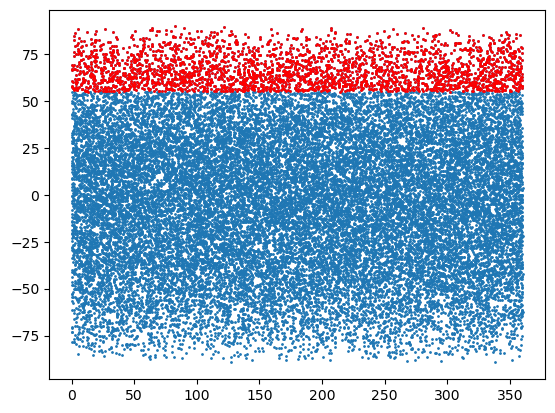

In [6]:
pole_cart = RectangularCoords.query_square(0, 90, 35)
plt.scatter(all_pointings[:, 0], all_pointings[:, 1], s=1)
plt.scatter(pole_cart[:, 0], pole_cart[:, 1], s=1, color="red")

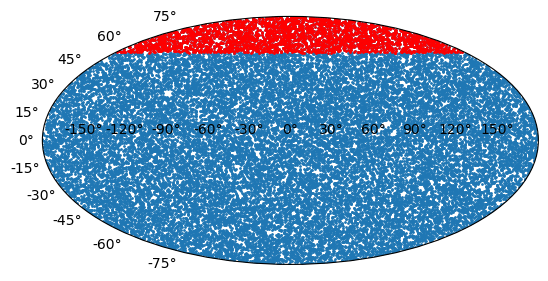

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection="mollweide")

ra_center = Angle(all_pointings[:, 0], u.degree)
dec_center = Angle(all_pointings[:, 1], u.degree)
ra_center = ra_center.wrap_at(180*u.degree)

ra_square = Angle(pole_cart[:, 0], u.degree)
dec_square = Angle(pole_cart[:, 1], u.degree)
ra_square = ra_square.wrap_at(180*u.degree)

ax.scatter(ra_center.radian, dec_center.radian, s=1)
ax.scatter(ra_square.radian, dec_square.radian, s=1, color="red")